# Exploring MovieLens Data

In [1]:
import os
DATA_DIR = '../resources/data/ml-100k'
user_path = os.path.abspath(DATA_DIR + '/u.user')
item_path = os.path.abspath(DATA_DIR + '/u.item')
rating_path = os.path.abspath(DATA_DIR + '/u.data')

In [2]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, LongType, DoubleType, TimestampType
user_schema = StructType([
    StructField("userId", IntegerType(), True),
    StructField("age", IntegerType(), True),
    StructField("gender", StringType(), True),
    StructField("occupation", StringType(), True),
    StructField("zipCode", StringType(), True)])

item_schema = StructType([
    StructField("itemId", IntegerType(), True),
    StructField("title", StringType(), True),
    StructField("releaseDate", StringType(), True),
    StructField("videoReleaseDate", StringType(), True),
    StructField("imbdUrl", StringType(), True),
    StructField("unknown", IntegerType(), True),
    StructField("action", IntegerType(), True),
    StructField("adventure", IntegerType(), True),
    StructField("animation", IntegerType(), True),
    StructField("children", IntegerType(), True),
    StructField("comedy", IntegerType(), True),
    StructField("crime", IntegerType(), True),
    StructField("documentary", IntegerType(), True),
    StructField("drama", IntegerType(), True),
    StructField("fantasy", IntegerType(), True),
    StructField("noir", IntegerType(), True),
    StructField("horror", IntegerType(), True),
    StructField("musical", IntegerType(), True),
    StructField("mystery", IntegerType(), True),
    StructField("romance", IntegerType(), True),
    StructField("sciFi", IntegerType(), True),
    StructField("thriller", IntegerType(), True),
    StructField("war", IntegerType(), True),
    StructField("western", StringType(), True)])

rating_schema = StructType([
    StructField("userId", IntegerType(), True),
    StructField("itemId", IntegerType(), True),
    StructField("rating", DoubleType(), True),
    StructField("timestamp", LongType(), True)])

In [3]:
userDf = spark.read.option("delimiter","|").csv('file://' + user_path, schema = user_schema)
itemDf = spark.read.option("delimiter","|").csv('file://' + item_path, schema = item_schema)
ratingDf = spark.read.option("delimiter","\t").csv('file://' + rating_path, schema = rating_schema)

In [4]:
from pyspark.sql import functions as f
sciFiMovies = itemDf.filter(f.col("sciFi") == 1).select("itemId", "title", "releaseDate")
ratingDf.join(sciFiMovies, ["itemId"], "inner").groupBy(
    "itemId", "title", "releaseDate"
).agg(
    f.avg("rating").alias("rating"),
    f.count("rating").alias("votes")
).sort(f.desc("rating")).show(5)

+------+--------------------+-----------+------------------+-----+
|itemId|               title|releaseDate|            rating|votes|
+------+--------------------+-----------+------------------+-----+
|  1293|     Star Kid (1997)|16-Jan-1998|               5.0|    3|
|    50|    Star Wars (1977)|01-Jan-1977|4.3584905660377355|  583|
|   474|Dr. Strangelove o...|01-Jan-1963| 4.252577319587629|  194|
|   172|Empire Strikes Ba...|01-Jan-1980| 4.204359673024523|  367|
|    89| Blade Runner (1982)|01-Jan-1982| 4.138181818181818|  275|
+------+--------------------+-----------+------------------+-----+
only showing top 5 rows



## Exploring User Dataset

In [5]:
import matplotlib.pyplot as plt
ages = userDf.select("age").rdd.flatMap(lambda x: x).collect()
plt.hist(ages, bins=20, color='C0', density=True)
plt.xlabel('Age')
plt.ylabel('Percent')
plt.title('Distribution of users by age')
fig = plt.gcf()
fig.set_size_inches(8, 5)

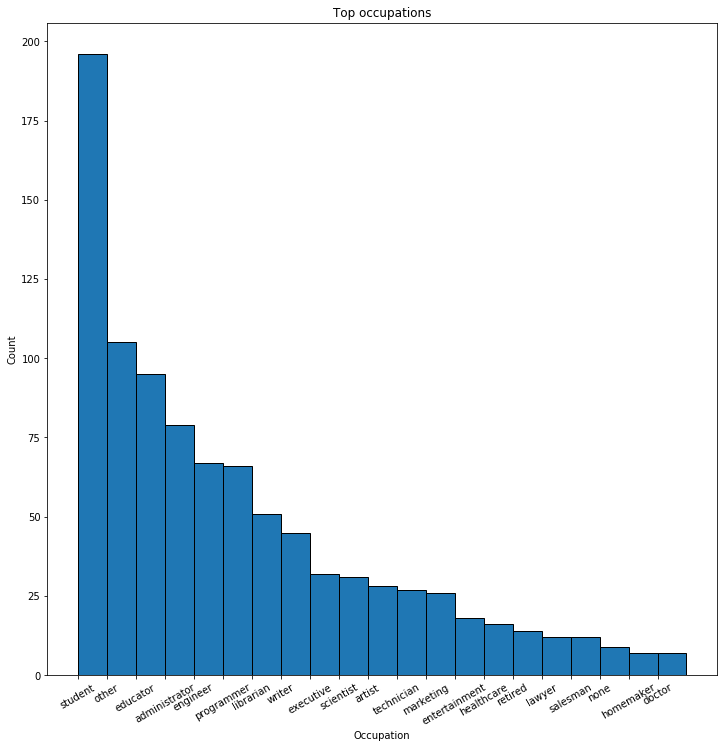

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Collect results
occupations = userDf.groupBy("occupation").agg(f.count("userId").alias("count")) \
                    .sort(f.desc("count")).collect()
occupation_titles = [row['occupation'] for row in occupations]
occupation_counts = [row['count'] for row in occupations]

# Plot
x_axis = np.array(occupation_titles)
y_axis = np.array(occupation_counts)
pos = np.arange(len(x_axis))

width = 1.0
ax = plt.axes()
ax.set_xticks(pos - (width / 2))
ax.set_xticklabels(x_axis)
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.title('Top occupations')
plt.bar(pos, y_axis, width, color='C0', edgecolor='black')
plt.xticks(rotation=30)
fig = plt.gcf()
fig.set_size_inches(12, 12)

## Exploring Movie Dataset

In [7]:
## UDF to extract year from release_date
def convert_year(x):
    try:
        return int(x[-4:])
    except:
        return 1900

from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
convert_year_udf = udf(convert_year, IntegerType())

### Distribution by release year  (Spark)

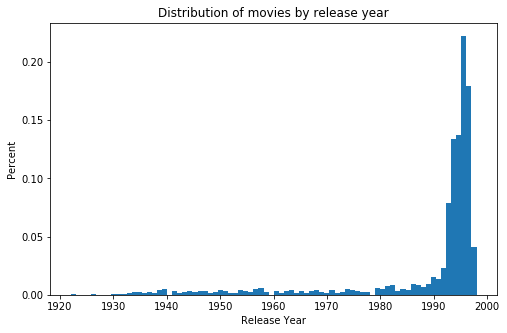

In [8]:
release_years = itemDf.select(convert_year_udf(f.col("releaseDate"))).alias("releaseYear") \
                      .rdd.flatMap(lambda x: x).collect()
release_years_filtered = list(filter(lambda x: x != 1900, release_years))
import matplotlib.pyplot as plt
plt.hist(release_years_filtered, bins=80, color='C0', density=True)
plt.xlabel('Release Year')
plt.ylabel('Percent')
plt.title('Distribution of movies by release year')
fig = plt.gcf()
fig.set_size_inches(8, 5)

### Distribution by release year (Python)

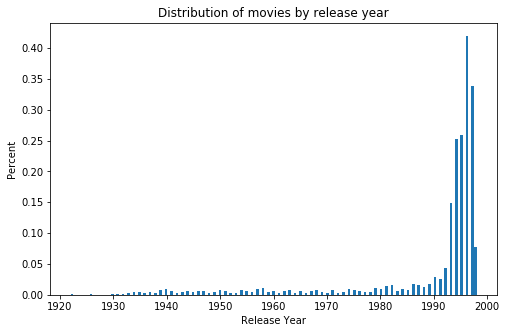

In [9]:
# Approach 2 - using python
release_dates_2 = itemDf.select("releaseDate").rdd.flatMap(lambda x: x).collect()
release_years_2 = [convert_year(x) for x in release_dates_2]
# Filtering Method 2
release_years_filtered_2 = [x for x in release_years_2 if x != 1900]
import matplotlib.pyplot as plt
plt.hist(release_years_filtered_2, bins='auto', color='C0', density=True)
plt.xlabel('Release Year')
plt.ylabel('Percent')
plt.title('Distribution of movies by release year')
fig = plt.gcf()
fig.set_size_inches(8, 5)

## Exploring Rating Dataset

### Matplot Distribution gives a probability distribution - not exact counts

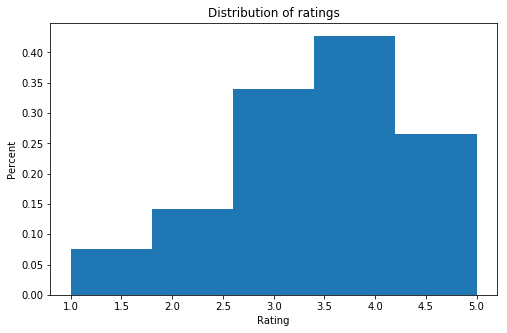

In [10]:
ratings = ratingDf.select("rating").rdd.flatMap(lambda x: x).collect()
import matplotlib.pyplot as plt
plt.hist(ratings, bins=5, color='C0', density=True)
plt.xlabel('Rating')
plt.ylabel('Percent')
plt.title('Distribution of ratings')
fig = plt.gcf()
fig.set_size_inches(8, 5)

### Getting exact values with GroupBy counts

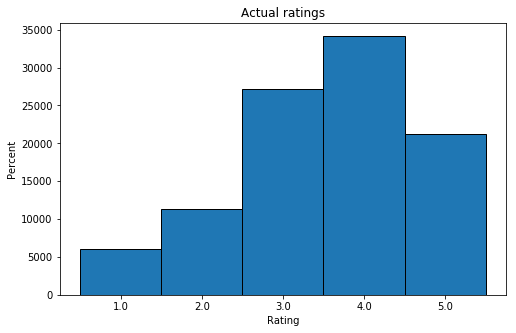

In [11]:
ratings_2 = ratingDf.groupBy("rating").agg(f.count("rating").alias("count")).collect()

# Sort by x-axis
ratings_2.sort(key=lambda x: x[0], reverse=False)
ratings_x = [row['rating'] for row in ratings_2]
ratings_y = [row['count'] for row in ratings_2]

# Plot
x_axis = np.array(ratings_x)
y_axis = np.array(ratings_y)
pos = np.arange(len(x_axis))

width = 1.0
ax = plt.axes()
ax.set_xticks(pos)
ax.set_xticklabels(x_axis)
plt.xlabel('Rating')
plt.ylabel('Percent')
plt.title('Actual ratings')
plt.bar(pos, y_axis, width, color='C0', edgecolor='black')
fig = plt.gcf()
fig.set_size_inches(8, 5)

### Sort by NORMALIZED y-axis, from largest to smallest

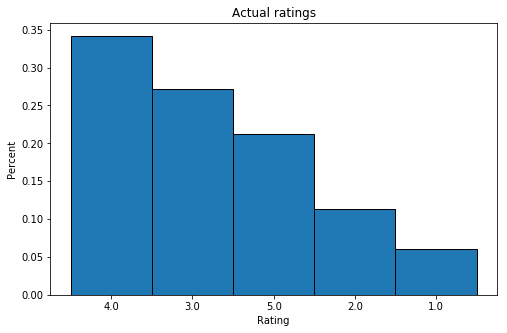

In [12]:
ratings_2.sort(key=lambda x: x[1], reverse=True)
ratings_x = [row['rating'] for row in ratings_2]
ratings_y = [row['count'] for row in ratings_2]

# Plot
x_axis = np.array(ratings_x)
y_axis = np.array(ratings_y)
y_axis_normed = y_axis / y_axis.sum()
pos = np.arange(len(x_axis))

width = 1.0
ax = plt.axes()
ax.set_xticks(pos)
ax.set_xticklabels(x_axis)
plt.xlabel('Rating')
plt.ylabel('Percent')
plt.title('Actual ratings')
plt.bar(pos, y_axis_normed, width, color='C0', edgecolor='black')
fig = plt.gcf()
fig.set_size_inches(8, 5)

### Collecting stats in Spark

In [13]:
ratingDf.agg(f.max("rating").alias("max"), f.min("rating").alias("min"), f.avg("rating").alias("avg")).show()
median = ratingDf.approxQuantile("rating", [0.5], 0.01)
print("median: ", median)

+---+---+-------+
|max|min|    avg|
+---+---+-------+
|5.0|1.0|3.52986|
+---+---+-------+

median:  [4.0]


### Collecting stats in Python

In [14]:
ratings = ratingDf.select("rating").rdd.flatMap(lambda x: x).collect()
max_rating = max(ratings)
min_rating = min(ratings)
mean_rating = sum(ratings) / len(ratings)
median_rating = np.median(ratings)
print("Min rating: %d" % min_rating)
print("Max rating: %d" % max_rating)
print("Average rating: %2.2f" % mean_rating)
print("Median rating: %d" % median_rating)

Min rating: 1
Max rating: 5
Average rating: 3.53
Median rating: 4


### Time Series chart of ratings
* Extract a dataset of movie ratings by date
* Chart a time series of the total number of ratings, number of unique users who gave a rating, and the number of unique movies rated, for each day.

In [15]:
ratings_per_date_df = ratingDf \
                        .withColumn('date', f.date_format(ratingDf.timestamp.cast(dataType=TimestampType()), "yyyy-MM-dd")) \
                        .groupBy('date').agg(
                            f.count('rating').alias('ratings'),
                            f.countDistinct('userId').alias('users'),
                            f.countDistinct('itemId').alias('items')
                        )

In [16]:
from datetime import datetime
ratings_par_date = ratings_per_date_df.sort(f.asc('date')).collect()
ratings_x_str = [row['date'] for row in ratings_par_date]
ratings_y1 = [row['ratings'] for row in ratings_par_date]
ratings_y2 = [row['users'] for row in ratings_par_date]
ratings_y3 = [row['items'] for row in ratings_par_date]
ratings_x = np.array([datetime.strptime(x, "%Y-%m-%d") for x in ratings_x_str])

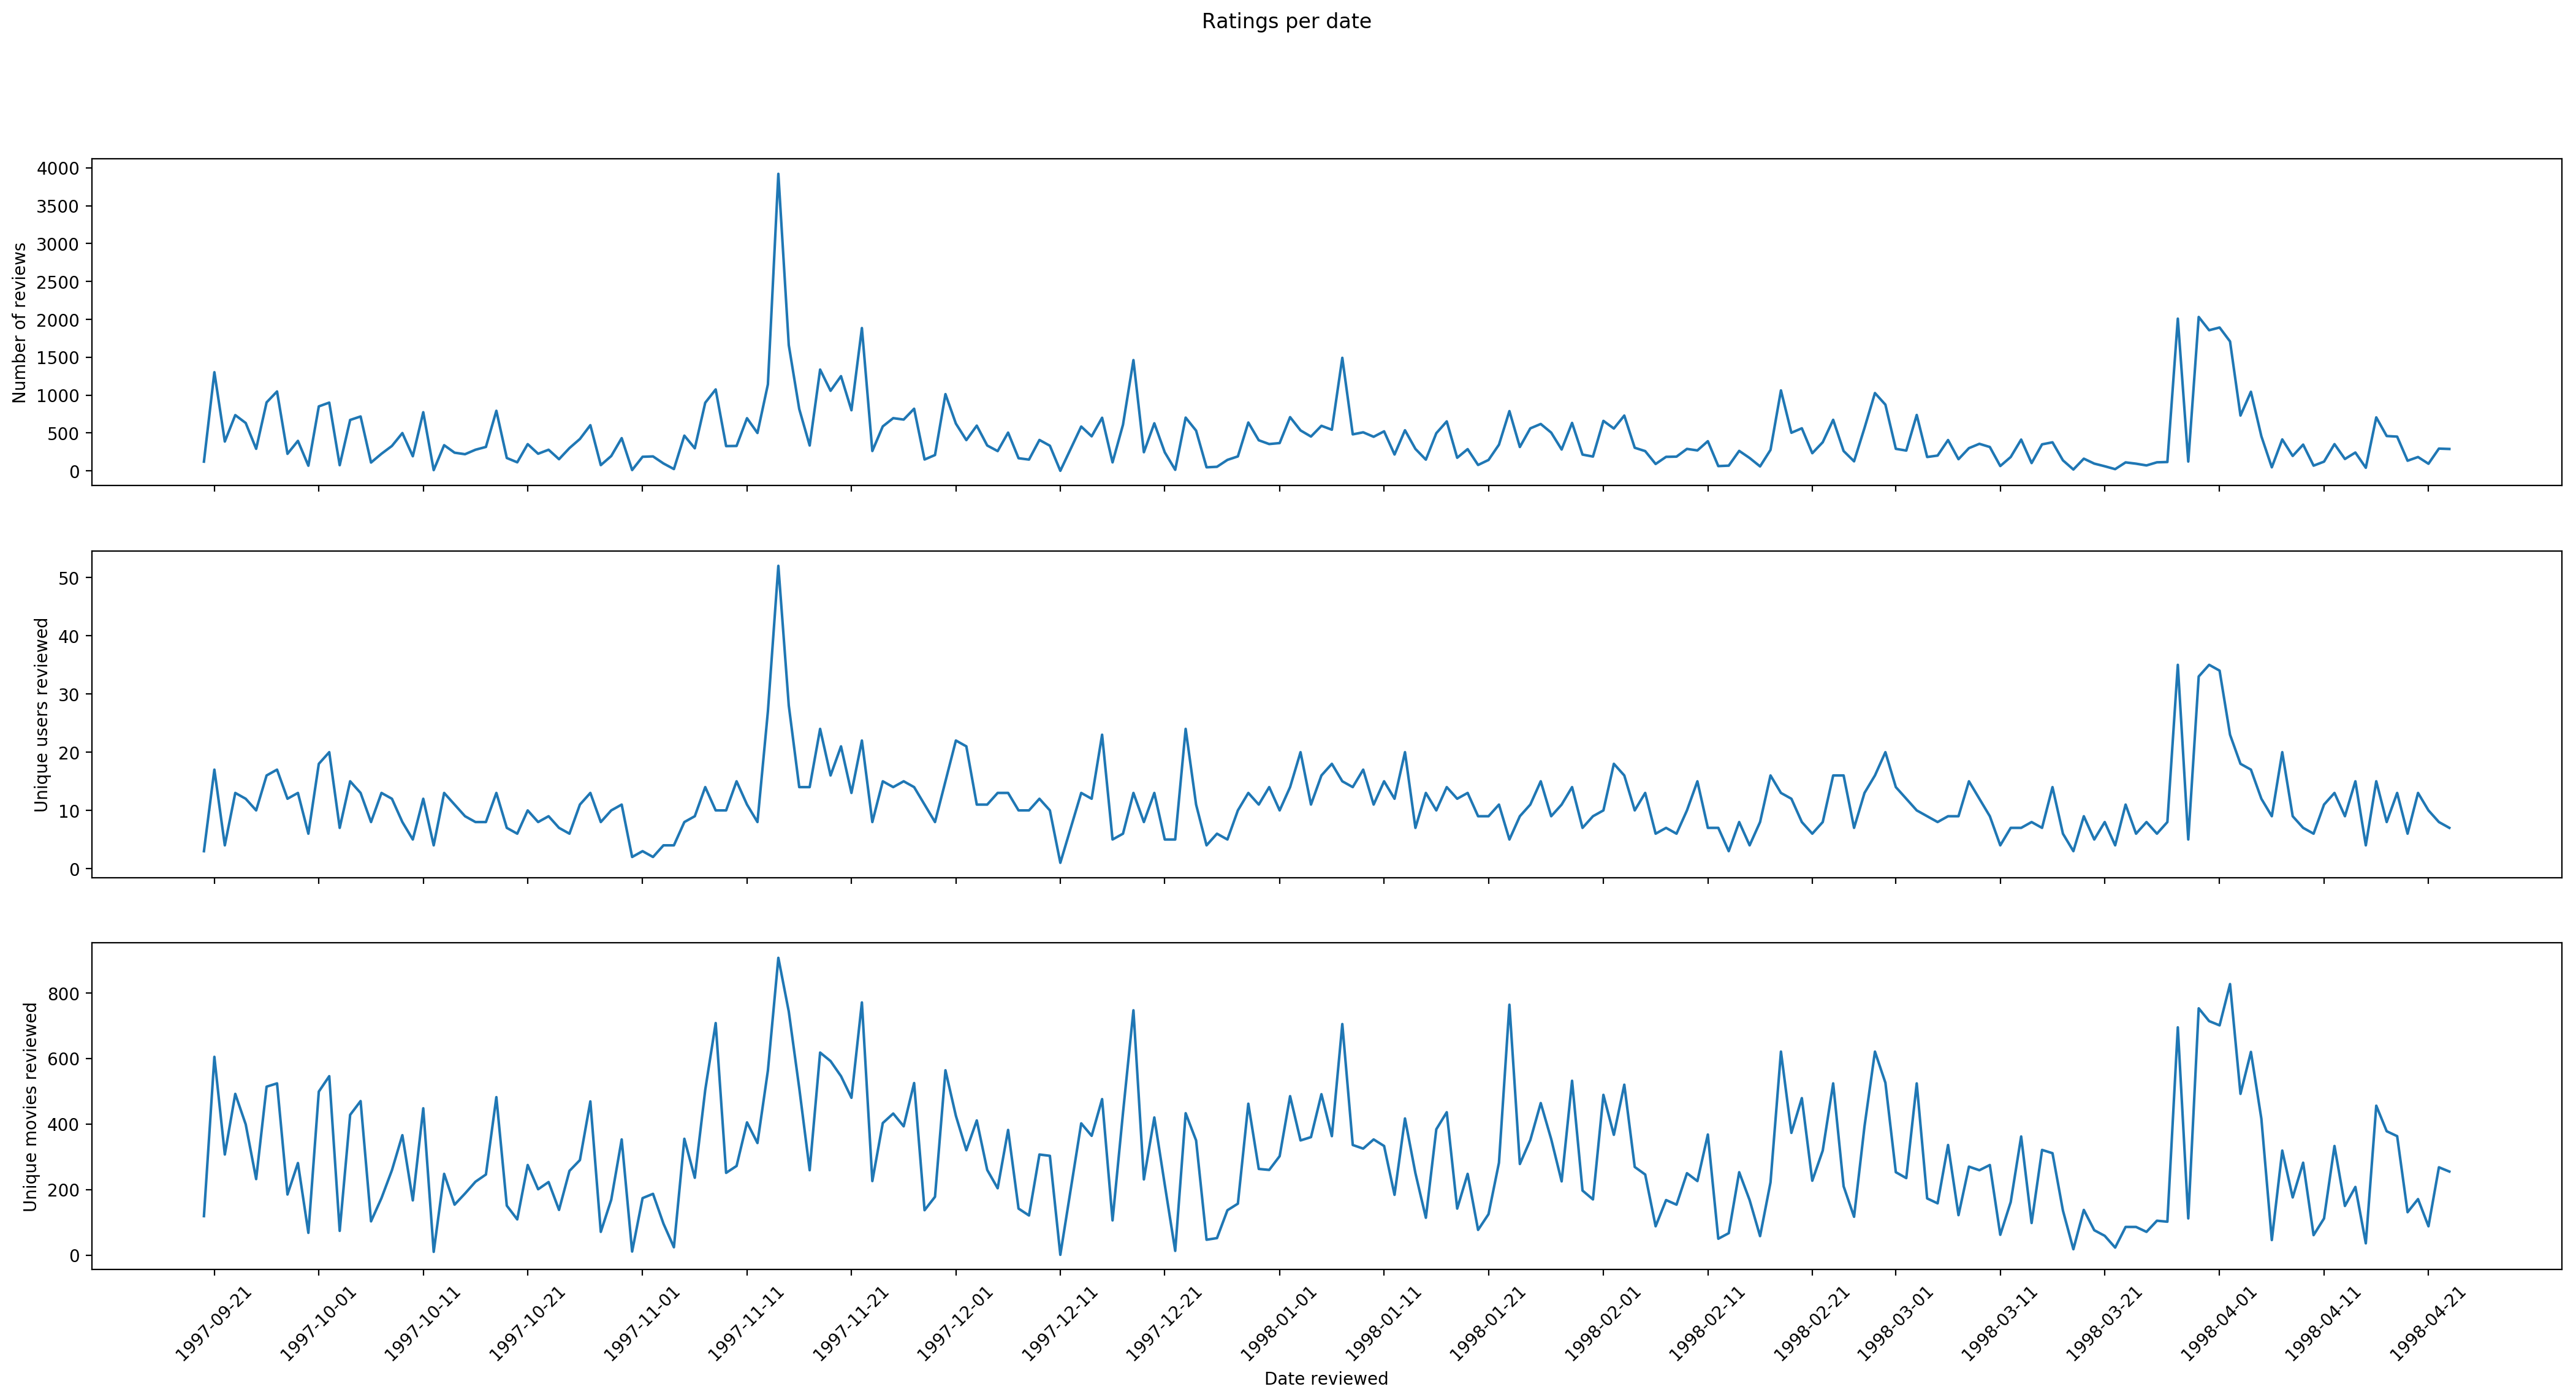

In [17]:
fig, axarr = plt.subplots(3, sharex=True, figsize=(26, 12), dpi=200, facecolor='w', edgecolor='k')
fig.suptitle('Ratings per date')
axarr[0].plot(ratings_x, ratings_y1)
axarr[0].set_ylabel('Number of reviews')
axarr[1].plot(ratings_x, ratings_y2)
axarr[1].set_ylabel('Unique users reviewed')
axarr[2].plot(ratings_x, ratings_y3)
axarr[2].set_ylabel('Unique movies reviewed')
plt.xlabel("Date reviewed")

# Uncomment the following lines to get more granular xticks
unique_months = np.unique([x[:9]+'1' for x in ratings_x_str if int(x[8])<3]).tolist()
unique_months_dt = [datetime.strptime(x, "%Y-%m-%d") for x in unique_months]
plt.xticks(unique_months_dt, unique_months, rotation=45)

plt.show()